# MLP on Simulated ORFs  
Start with ORF_MLP_118 which had the simulator bug fix.  
Evaluate MLP with fewer neurons.  
Train on copious simulated data.  
Use uniform but realistic RNA lengths.  
Similar 74% accuracy.

In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-08-17 14:40:38 EDT


In [2]:
PC_TRAINS=50000
NC_TRAINS=50000
PC_TESTS=5000
NC_TESTS=5000   
RNA_LEN=1000  
MAX_K = 3 
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=32
DROP_RATE=0.30
EPOCHS=200
SPLITS=3
FOLDS=3   # make this 5 for serious testing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

2021-08-17 14:40:39.206904: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import Collection_Generator, Transcript_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/DataPrep.py')
    with open('DataPrep.py', 'w') as f:
        f.write(r.text)  
    from DataPrep import DataPrep
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.RNA_gen import Collection_Generator, Transcript_Oracle
        from SimTools.KmerTools import KmerTools
        from SimTools.DataPrep import DataPrep
BESTMODELPATH=DATAPATH+"BestModel"  # saved on cloud instance and lost after logout
LASTMODELPATH=DATAPATH+"LastModel"  # saved on Google Drive but requires login

CoLab not working. On my PC, use relative paths.


## Data Load


In [5]:
show_time()
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN)
pc_all = pc_sim.get_sequences(PC_TRAINS+PC_TESTS)
nc_all = nc_sim.get_sequences(NC_TRAINS+NC_TESTS)
print("Generated",len(pc_all),"PC seqs")
print("Generated",len(nc_all),"NC seqs")
pc_sim=None
nc_sim=None

2021-08-17 14:40:39 EDT
Generated 55000 PC seqs
Generated 55000 NC seqs


In [6]:
print("Simulated sequence characteristics:")
oc = ORF_counter()
print("PC seqs")
oc.describe_sequences(pc_all)
print("NC seqs")
oc.describe_sequences(nc_all)
oc=None
show_time()

Simulated sequence characteristics:
PC seqs
Average RNA length: 1000.0
Average ORF length: 673.7844545454545
NC seqs
Average RNA length: 1000.0
Average ORF length: 179.54612727272726
2021-08-17 14:41:01 EDT


## Data Prep

In [7]:
dp = DataPrep()
Xseq,y=dp.combine_pos_and_neg(pc_all,nc_all)
nc_all=None
pc_all=None
nc_all=None
print("The first few shuffled labels:")
print(y[:30])
show_time()

The first few shuffled labels:
[1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0]
2021-08-17 14:41:01 EDT


In [8]:
Xfrq=KmerTools.seqs_to_kmer_freqs(Xseq,MAX_K)
Xseq = None
y=np.asarray(y)
show_time()

2021-08-17 14:41:24 EDT


In [9]:
# Assume X and y were shuffled.
train_size=PC_TRAINS+NC_TRAINS
X_train=Xfrq[:train_size] 
X_test=Xfrq[train_size:]
y_train=y[:train_size] 
y_test=y[train_size:]
print("Training set size=",len(X_train),"=",len(y_train))
print("Reserved test set size=",len(X_test),"=",len(y_test))
Xfrq=None
y=None
show_time()

Training set size= 100000 = 100000
Reserved test set size= 10000 = 10000
2021-08-17 14:41:24 EDT


## Neural network

In [10]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2720      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)        

2021-08-17 14:41:24.367478: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-17 14:41:24.416972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-17 14:41:24.417944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-17 14:41:24.417980: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-17 14:41:24.421035: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-17 14:41:24.421081: I tensorflow/stream_executor

In [11]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=BESTMODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    # No need to shuffle here assuming data was shuffled above.
    splitter = KFold(n_splits=SPLITS,shuffle=False) 
    model = None
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

2021-08-17 14:41:24 EDT
MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200


2021-08-17 14:41:25.015859: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-17 14:41:25.032744: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496000000 Hz
2021-08-17 14:41:31.378414: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 154/2084 [=>............................] - ETA: 1s - loss: 0.7390 - accuracy: 0.4956 

2021-08-17 14:41:31.700276: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


2084/2084 [==============================] - 9s 1ms/step - loss: 0.7069 - accuracy: 0.5006 - val_loss: 0.6936 - val_accuracy: 0.4978


2021-08-17 14:41:34.647981: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 2/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6938 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.4978
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6933 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5022
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 4/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6933 - accuracy: 0.5009 - val_loss: 0.6933 - val_accuracy: 0.4978
Epoch 5/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6930 - val_accuracy: 0.4978
Epoch 6/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6930 - accuracy: 0.5043 - val_loss: 0.6894 - val_accuracy: 0.5024
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 7/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6891 - accuracy: 0.5359 -

2084/2084 [==============================] - 3s 1ms/step - loss: 0.5701 - accuracy: 0.7047 - val_loss: 0.5418 - val_accuracy: 0.7309
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 47/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5746 - accuracy: 0.6976 - val_loss: 0.5409 - val_accuracy: 0.7316
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 48/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5729 - accuracy: 0.7019 - val_loss: 0.5394 - val_accuracy: 0.7314
Epoch 49/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5720 - accuracy: 0.7018 - val_loss: 0.5406 - val_accuracy: 0.7308
Epoch 50/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5695 - accuracy: 0.7069 - val_loss: 0.5383 - val_accuracy: 0.7310
Epoch 51/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5713 - accuracy: 0.7041 - val_loss: 0.5386 - val_accuracy: 0.7326
INFO:tensorflow:Assets 

2084/2084 [==============================] - 3s 1ms/step - loss: 0.5516 - accuracy: 0.7159 - val_loss: 0.5289 - val_accuracy: 0.7375
Epoch 94/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5491 - accuracy: 0.7209 - val_loss: 0.5315 - val_accuracy: 0.7379
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 95/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5528 - accuracy: 0.7164 - val_loss: 0.5297 - val_accuracy: 0.7380
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 96/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5507 - accuracy: 0.7214 - val_loss: 0.5320 - val_accuracy: 0.7371
Epoch 97/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5536 - accuracy: 0.7175 - val_loss: 0.5294 - val_accuracy: 0.7382
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 98/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5539 - accuracy: 0.7187 - val_lo

Epoch 144/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5466 - accuracy: 0.7244 - val_loss: 0.5266 - val_accuracy: 0.7398
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 145/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5487 - accuracy: 0.7203 - val_loss: 0.5258 - val_accuracy: 0.7401
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 146/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5435 - accuracy: 0.7246 - val_loss: 0.5263 - val_accuracy: 0.7397
Epoch 147/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5448 - accuracy: 0.7258 - val_loss: 0.5257 - val_accuracy: 0.7401
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 148/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5443 - accuracy: 0.7243 - val_loss: 0.5271 - val_accuracy: 0.7399
Epoch 149/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5427 - accura

2084/2084 [==============================] - 3s 1ms/step - loss: 0.5420 - accuracy: 0.7267 - val_loss: 0.5258 - val_accuracy: 0.7395
Epoch 197/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5436 - accuracy: 0.7284 - val_loss: 0.5274 - val_accuracy: 0.7396
Epoch 198/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5411 - accuracy: 0.7293 - val_loss: 0.5247 - val_accuracy: 0.7396
Epoch 199/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5423 - accuracy: 0.7255 - val_loss: 0.5255 - val_accuracy: 0.7405
Epoch 200/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5405 - accuracy: 0.7283 - val_loss: 0.5259 - val_accuracy: 0.7386
Fold 1, 200 epochs, 544 sec


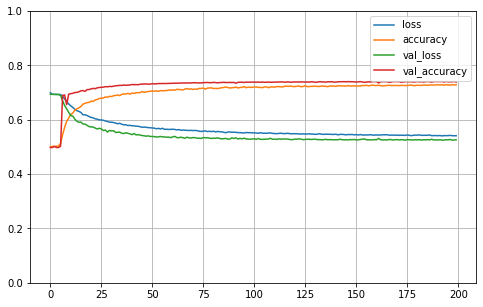

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7028 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.5026
Epoch 2/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6939 - accuracy: 0.4955 - val_loss: 0.6931 - val_accuracy: 0.5934
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6935 - accuracy: 0.4958 - val_loss: 0.6935 - val_accuracy: 0.4974
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5031 - val_loss: 0.6932 - val_accuracy: 0.5026
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6933 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.5029
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5020 - val_loss: 0.6927 - val_accuracy: 0.5026
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6918 - a

Epoch 57/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5696 - accuracy: 0.7067 - val_loss: 0.5359 - val_accuracy: 0.7331
Epoch 58/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5658 - accuracy: 0.7085 - val_loss: 0.5354 - val_accuracy: 0.7331
Epoch 59/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5684 - accuracy: 0.7073 - val_loss: 0.5357 - val_accuracy: 0.7328
Epoch 60/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5652 - accuracy: 0.7067 - val_loss: 0.5367 - val_accuracy: 0.7329
Epoch 61/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5654 - accuracy: 0.7092 - val_loss: 0.5343 - val_accuracy: 0.7339
Epoch 62/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5670 - accuracy: 0.7062 - val_loss: 0.5369 - val_accuracy: 0.7330
Epoch 63/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5634 - accuracy: 0.7115 - val_loss: 0.5332 -

2084/2084 [==============================] - 3s 1ms/step - loss: 0.5527 - accuracy: 0.7166 - val_loss: 0.5262 - val_accuracy: 0.7364
Epoch 114/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5523 - accuracy: 0.7182 - val_loss: 0.5270 - val_accuracy: 0.7376
Epoch 115/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5517 - accuracy: 0.7203 - val_loss: 0.5271 - val_accuracy: 0.7377
Epoch 116/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5499 - accuracy: 0.7217 - val_loss: 0.5270 - val_accuracy: 0.7382
Epoch 117/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5509 - accuracy: 0.7212 - val_loss: 0.5251 - val_accuracy: 0.7369
Epoch 118/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5526 - accuracy: 0.7180 - val_loss: 0.5250 - val_accuracy: 0.7373
Epoch 119/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5500 - accuracy: 0.7237 - val_loss: 0.5249 - val_ac

Epoch 169/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5436 - accuracy: 0.7253 - val_loss: 0.5241 - val_accuracy: 0.7381
Epoch 170/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5415 - accuracy: 0.7263 - val_loss: 0.5254 - val_accuracy: 0.7382
Epoch 171/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5459 - accuracy: 0.7235 - val_loss: 0.5242 - val_accuracy: 0.7383
Epoch 172/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5466 - accuracy: 0.7251 - val_loss: 0.5237 - val_accuracy: 0.7388
Epoch 173/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5423 - accuracy: 0.7277 - val_loss: 0.5241 - val_accuracy: 0.7389
Epoch 174/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5442 - accuracy: 0.7258 - val_loss: 0.5237 - val_accuracy: 0.7389
Epoch 175/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5454 - accuracy: 0.7225 - val_loss: 0

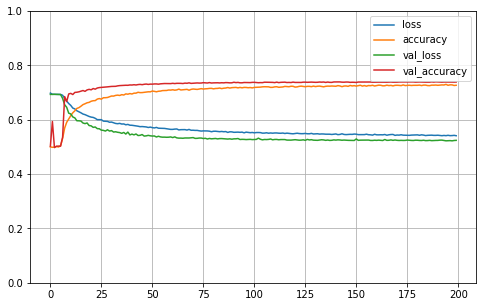

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7029 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 2/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6938 - accuracy: 0.5010 - val_loss: 0.6937 - val_accuracy: 0.4970
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6935 - accuracy: 0.4992 - val_loss: 0.6934 - val_accuracy: 0.4970
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6933 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.4970
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6930 - accuracy: 0.5059 - val_loss: 0.6896 - val_accuracy: 0.6534
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6886 - a

Epoch 57/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5695 - accuracy: 0.7049 - val_loss: 0.5373 - val_accuracy: 0.7351
Epoch 58/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5650 - accuracy: 0.7105 - val_loss: 0.5378 - val_accuracy: 0.7349
Epoch 59/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5677 - accuracy: 0.7069 - val_loss: 0.5372 - val_accuracy: 0.7344
Epoch 60/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5648 - accuracy: 0.7098 - val_loss: 0.5363 - val_accuracy: 0.7353
Epoch 61/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5619 - accuracy: 0.7102 - val_loss: 0.5365 - val_accuracy: 0.7357
Epoch 62/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5632 - accuracy: 0.7112 - val_loss: 0.5369 - val_accuracy: 0.7341
Epoch 63/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5635 - accuracy: 0.7086 - val_loss: 0.5354 -

2084/2084 [==============================] - 3s 1ms/step - loss: 0.5515 - accuracy: 0.7200 - val_loss: 0.5272 - val_accuracy: 0.7372
Epoch 114/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5503 - accuracy: 0.7222 - val_loss: 0.5278 - val_accuracy: 0.7382
Epoch 115/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5492 - accuracy: 0.7203 - val_loss: 0.5298 - val_accuracy: 0.7366
Epoch 116/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5462 - accuracy: 0.7235 - val_loss: 0.5274 - val_accuracy: 0.7389
Epoch 117/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5498 - accuracy: 0.7185 - val_loss: 0.5274 - val_accuracy: 0.7375
Epoch 118/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5505 - accuracy: 0.7205 - val_loss: 0.5277 - val_accuracy: 0.7388
Epoch 119/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5509 - accuracy: 0.7179 - val_loss: 0.5277 - val_ac

Epoch 169/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5472 - accuracy: 0.7241 - val_loss: 0.5256 - val_accuracy: 0.7383
Epoch 170/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5425 - accuracy: 0.7260 - val_loss: 0.5252 - val_accuracy: 0.7384
Epoch 171/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5430 - accuracy: 0.7269 - val_loss: 0.5247 - val_accuracy: 0.7384
Epoch 172/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5440 - accuracy: 0.7283 - val_loss: 0.5255 - val_accuracy: 0.7379
Epoch 173/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5446 - accuracy: 0.7256 - val_loss: 0.5256 - val_accuracy: 0.7380
Epoch 174/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5443 - accuracy: 0.7263 - val_loss: 0.5268 - val_accuracy: 0.7383
Epoch 175/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5418 - accuracy: 0.7309 - val_loss: 0

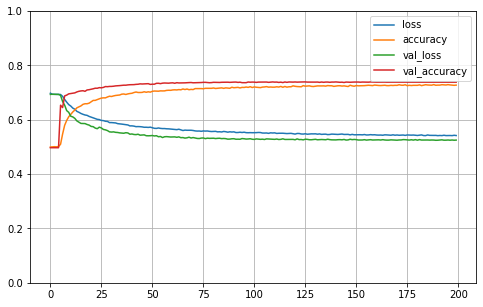

In [12]:
show_time()
last_model = do_cross_validation(X_train,y_train)
best_model = load_model(BESTMODELPATH)

In [13]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Accuracy on training data.
2021-08-17 15:07:18 EDT


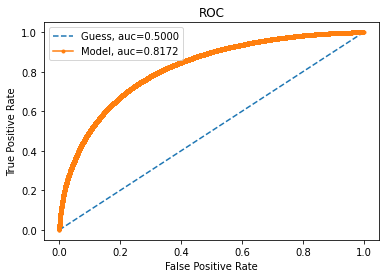

AUC: 81.72%
accuracy: 73.99%
2021-08-17 15:07:20 EDT


In [14]:
print("Accuracy on training data.")
show_time()
show_test_AUC(best_model,X_train,y_train)
show_test_accuracy(best_model,X_train,y_train)
show_time()

Accuracy on test data.
2021-08-17 15:07:20 EDT


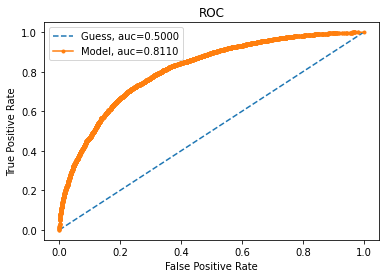

AUC: 81.10%
accuracy: 73.44%
2021-08-17 15:07:21 EDT


In [15]:
print("Accuracy on test data.")
show_time()
show_test_AUC(last_model,X_test,y_test)
show_test_accuracy(best_model,X_test,y_test)
show_time()